# **Design and implementation of a reconfigurable FIR filter in FPGA**

### *Students:* Nagaro Gianmarco, Ninni Daniele, Rodrigues Vero Filho Emerson, Valentini Lorenzo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from serial import Serial
from scipy.signal import firwin, freqz, lfilter, square, sawtooth, gausspulse, unit_impulse

## **1)** *Definition of some handy functions*

In [2]:
# define function that sends FIR coefficients to the FPGA
def coeffs_set(port, baudrate, coeffs):
    ser = Serial(port=port, baudrate=baudrate)
    print('Sending FIR coefficients to the FPGA...')
    for i, coeff in enumerate(coeffs):
        coeff_int = round(coeff)
        coeff_bytes = coeff_int.to_bytes(length=1, byteorder='big', signed=True)
        #print(f'Sending coefficient #{i}: {coeff_int} ({coeff_bytes})...')
        ser.write(coeff_bytes)
    print("Done!")
    ser.close()

# define function that adds sinusoidal noise to a signal
def add_noise(t, signal, ampl, freq, phase):
    noise = ampl*np.sin(2*np.pi*freq*t + phase)
    return signal + noise

# define function that normalizes the amplitude of a signal to the input data range
def amplitude_normalize(signal_noiseless, signal_noisy):
    K = (input_th-1) / max(abs(signal_noisy)) # normalization constant
    return K*signal_noiseless, K*signal_noisy

# define function that filters a signal through the FPGA
def fir_fpga(port, baudrate, signal):
    ser = Serial(port=port, baudrate=baudrate)
    signal_filtered = []
    print("Filtering the signal through the FPGA...")
    for value in signal:
        value_int = round(value)
        value_bytes = value_int.to_bytes(length=1, byteorder='big', signed=True)
        ser.write(value_bytes)
        d = ser.read()
        value_filtered = int.from_bytes(bytes=d, byteorder='big', signed=True)
        signal_filtered.append(value_filtered)
    print("Done!")
    ser.close()
    return signal_filtered

# define function that filters a signal through Python script
def fir_python(coeffs, signal):
    print('Filtering the signal through Python script...')
    signal_filtered = lfilter(b=coeffs, a=1, x=signal)
    print('Done!')
    return signal_filtered

# define function that plots signals
def plot_signals(t, input_noiseless, input_noisy, output_fpga, output_python, title):
    delay = 0 # (taps-1) / (2*sampling_freq)
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.plot(t,       input_noiseless, color='black', label='input noiseless')
    ax.plot(t,       input_noisy,     color='black', label='input noisy', alpha=.3)
    ax.plot(t-delay, output_fpga,     color='red',   label='output FPGA')
    ax.plot(t-delay, output_python,   color='green', label='output Python')
    ax.set_xlabel('$t$ [$ms$]')
    ax.set_xlim(t[0], t[-1])
    ax.set_xticks(np.linspace(t[0], t[-1], 11))
    ax.set_xticklabels(np.around(1000*np.linspace(t[0], t[-1], 11), decimals=1))
    ax.set_ylim(-10*((input_th//10)+1), 10*((input_th//10)+1))
    ax.set_yticks(np.linspace(-10*((input_th//10)+1), 10*((input_th//10)+1), 14))
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.grid(alpha=0.2)
    plt.savefig('./img/'+title.lower().replace(" ", "_")+'.png')
    plt.show()

# define function that processes a input signal
def process_signal(t, input_noiseless, input_noisy, coeffs, title):
    input_noiseless, input_noisy = amplitude_normalize(input_noiseless, input_noisy)
    output_fpga = fir_fpga(port, baudrate, input_noisy)
    print('')
    output_python = fir_python(coeffs, input_noisy)
    plot_signals(t, input_noiseless, input_noisy, output_fpga, output_python, title)
    return

## **2)** *Computation of the input data range*

In [3]:
data_width = 8
input_th = 2**(data_width-1)

print(f'Input data: {data_width}-bit signed integer')
print(f'Input data range: [{-input_th}, {input_th-1}]')

Input data: 8-bit signed integer
Input data range: [-128, 127]


## **3)** *Design of the FIR filter*

In [4]:
taps = 35               # number of taps
sampling_freq = 48000   # sampling frequency   [Hz] 
cutoff_freq = 6000      # cutoff frequency     [Hz]
width = 6500            # transition bandwidth [Hz]
filter_type = 'lowpass' # 'bandpass', 'lowpass', 'highpass', 'bandstop'
coeffs = firwin(numtaps=taps, cutoff=cutoff_freq, width=width, pass_zero=filter_type, fs=sampling_freq)

print('Number of taps:', taps)
print('Sampling frequency:', sampling_freq, 'Hz')
print('Cutoff frequency:', cutoff_freq, 'Hz')
print('Transition bandwidth:', width, 'Hz')
print('Filter type:', filter_type, '\n')
print('FIR coefficients:\n', coeffs)

Number of taps: 35
Sampling frequency: 48000 Hz
Cutoff frequency: 6000 Hz
Transition bandwidth: 6500 Hz
Filter type: lowpass 

FIR coefficients:
 [ 6.51350396e-05 -1.49952348e-19 -4.96311977e-04 -1.36111005e-03
 -1.68582343e-03  1.42980333e-18  4.26283488e-03  8.96931480e-03
  9.14433832e-03 -4.45877440e-18 -1.78164964e-02 -3.45520322e-02
 -3.35163609e-02  8.08024968e-18  6.75614866e-02  1.51939188e-01
  2.22487426e-01  2.49996824e-01  2.22487426e-01  1.51939188e-01
  6.75614866e-02  8.08024968e-18 -3.35163609e-02 -3.45520322e-02
 -1.78164964e-02 -4.45877440e-18  9.14433832e-03  8.96931480e-03
  4.26283488e-03  1.42980333e-18 -1.68582343e-03 -1.36111005e-03
 -4.96311977e-04 -1.49952348e-19  6.51350396e-05]


## **4)** *Plot of the FIR coefficients*

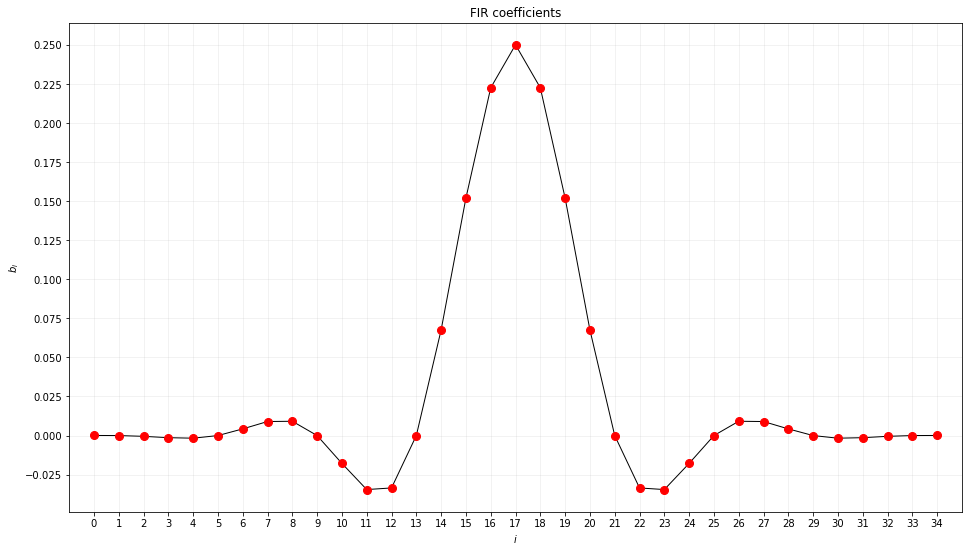

In [5]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(coeffs, linestyle='-', linewidth=1, color='black', marker='o', markersize=8, markeredgecolor='red', markerfacecolor='red')
ax.set_xlim(-1, taps)
ax.set_xticks(np.arange(0, taps))
ax.set_xlabel('$i$')
ax.set_yticks([i*np.max(coeffs)/10 for i in range(-1, 11)])
ax.set_ylabel('$b_{i}$')
ax.set_title('FIR coefficients')
ax.grid(alpha=0.2)
plt.savefig('./img/fir_coefficients.png')
plt.show()

## **5)** *Plot of the frequency response*

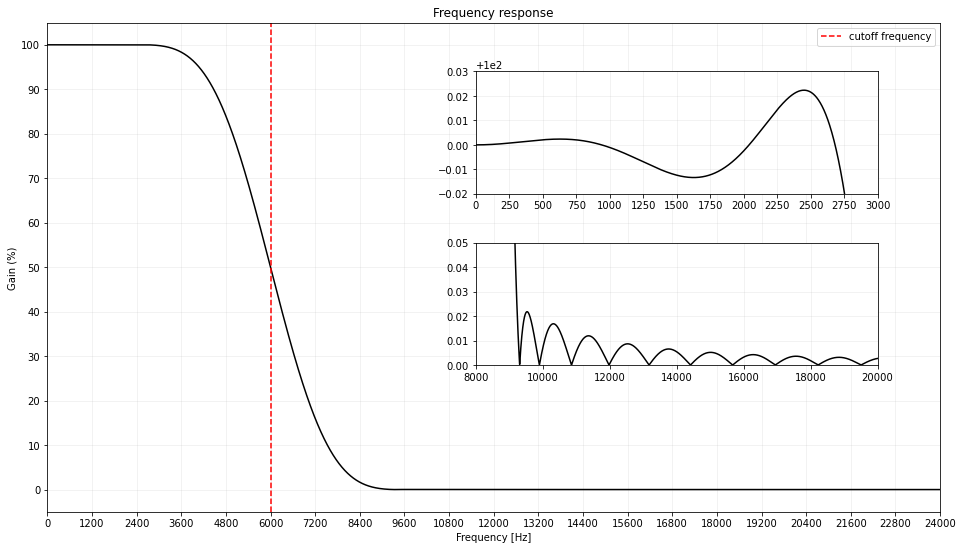

In [6]:
nyq_freq = 0.5*sampling_freq # Nyquist frequency
w, h = freqz(b=coeffs, worN=20*512)

# main plot
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot((w/np.pi)*nyq_freq, 100*np.abs(h), color='black')
ax.set_xlim(0, nyq_freq)
ax.set_xticks(np.linspace(0, nyq_freq, 21))
ax.set_ylim(-5, 105)
ax.set_yticks(100*np.linspace(0, 1, 11))
ax.axvline(cutoff_freq, color='red', label='cutoff frequency', linestyle='--')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Gain (%)')
ax.set_title('Frequency response')
ax.legend(loc='upper right')
ax.grid(alpha=0.2)

# upper inset plot
ax1 = ax.inset_axes([0.48, 0.65, .45, .25])
ax1.plot((w/np.pi)*nyq_freq, 100*np.abs(h), color='black')
ax1.set_xlim(max(cutoff_freq-2*width, 0), cutoff_freq-(6*width/13))
ax1.set_xticks(np.linspace(max(cutoff_freq-2*width, 0), cutoff_freq-(6*width/13), 13).astype(int))
ax1.set_ylim(100-0.02, 100+0.03)
ax1.set_yticks(100*np.linspace(1-0.0002, 1+0.0003, 6))
ax1.grid(alpha=0.2)

# lower inset plot
ax2 = ax.inset_axes([0.48, 0.3, .45, .25])
ax2.plot((w/np.pi)*nyq_freq, 100*np.abs(h), color='black')
ax2.set_xlim(cutoff_freq+(4*width/13), cutoff_freq+(28*width/13))
ax2.set_xticks(np.linspace(cutoff_freq+(4*width/13), cutoff_freq+(28*width/13), 7).astype(int))
ax2.set_ylim(0, 0.05)
ax2.set_yticks(100*np.linspace(0, 0.0005, 6))
ax2.grid(alpha=0.2)

plt.savefig('./img/frequency_response.png')
plt.show()

## **5)** *Sending of the FIR coefficients to the FPGA*

- Put the FPGA in *setting mode* (*SW0* off $\to$ *LD0* red)
- Run the following code cell
- Wait until all coefficients are received by the FPGA (*LD0* green)

In [7]:
port = 'COM4'                 # serial port
baudrate = 115200             # baud rate
coeffs_norm = input_th*coeffs # FIR coefficients normalized to the input data range

print('Serial port:', port)
print('Baud rate:', baudrate, '\n')
print('Normalized FIR coefficients:\n', coeffs_norm, '\n')

coeffs_set(port, baudrate, coeffs_norm)

Serial port: COM4
Baud rate: 115200 

Normalized FIR coefficients:
 [ 8.33728507e-03 -1.91939005e-17 -6.35279330e-02 -1.74222086e-01
 -2.15785399e-01  1.83014826e-16  5.45642865e-01  1.14807229e+00
  1.17047531e+00 -5.70723123e-16 -2.28051154e+00 -4.42266012e+00
 -4.29009419e+00  1.03427196e-15  8.64787028e+00  1.94482160e+01
  2.84783905e+01  3.19995935e+01  2.84783905e+01  1.94482160e+01
  8.64787028e+00  1.03427196e-15 -4.29009419e+00 -4.42266012e+00
 -2.28051154e+00 -5.70723123e-16  1.17047531e+00  1.14807229e+00
  5.45642865e-01  1.83014826e-16 -2.15785399e-01 -1.74222086e-01
 -6.35279330e-02 -1.91939005e-17  8.33728507e-03] 

Sending FIR coefficients to the FPGA...
Done!


## **6)** *Definition of the input data features*

In [8]:
# input signal
signal_freq = cutoff_freq/6                            # frequency [Hz]
n_osc = 5                                              # number of sampled complete oscillations
n_samples = int(n_osc*(sampling_freq/signal_freq))     # number of samples
t = np.linspace(0, n_samples/sampling_freq, n_samples) # sampling time values [s]

# sinusoidal noise
noise_ampl = 0.5                                       # amplitude
noise_freq = 2.5*cutoff_freq                           # frequency [Hz]
noise_phase = 0.8                                      # initial phase

print('INPUT SIGNAL')
print('Frequency:', signal_freq, 'Hz')
print('Number of sampled complete oscillations:', n_osc)
print('Number of samples:', n_samples)

print('\nSINUSOIDAL NOISE')
print('Amplitude:', noise_ampl)
print('Frequency:', noise_freq, 'Hz')
print('Initial phase:', noise_phase)

INPUT SIGNAL
Frequency: 1000.0 Hz
Number of sampled complete oscillations: 5
Number of samples: 240

SINUSOIDAL NOISE
Amplitude: 0.5
Frequency: 15000.0 Hz
Initial phase: 0.8


## **7)** *Filtering of sample input signals*

- Put the FPGA in *filtering mode* (*SW0* on $\to$ *LD0* blue)
- Run the following code cells

### **7.1)** *Sinusoidal wave*

Filtering the signal through the FPGA...
Done!

Filtering the signal through Python script...
Done!


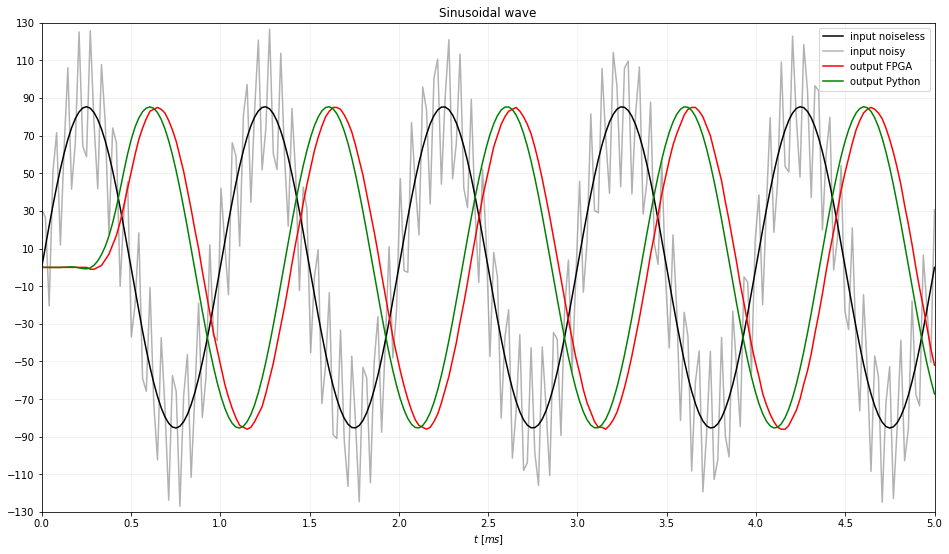

In [9]:
sin = np.sin(2*np.pi*signal_freq*t)
sin_noisy = add_noise(t, sin, noise_ampl, noise_freq, noise_phase)
process_signal(t, sin, sin_noisy, coeffs, 'Sinusoidal wave')

### **7.2)** *Square wave*

Filtering the signal through the FPGA...
Done!

Filtering the signal through Python script...
Done!


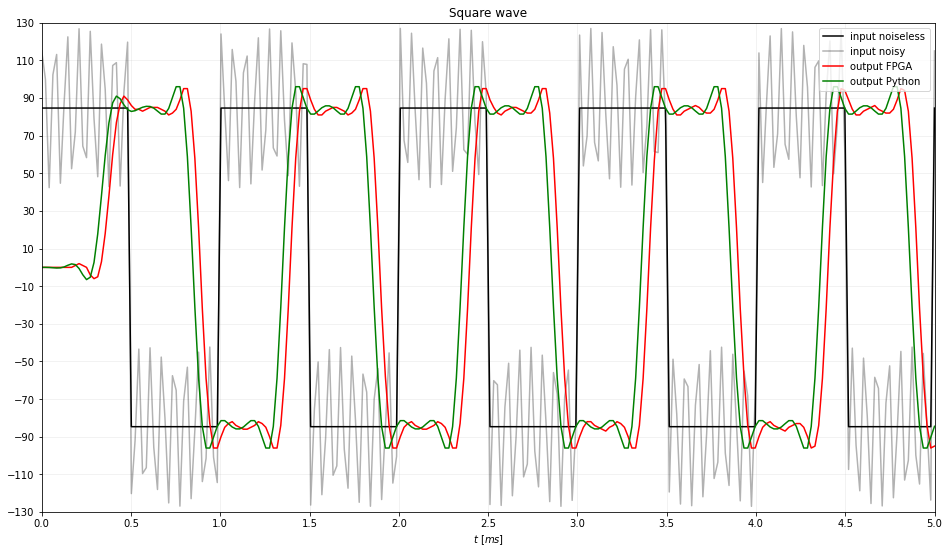

In [10]:
sqr = square(2*np.pi*signal_freq*t)
sqr_noisy = add_noise(t, sqr, noise_ampl, noise_freq, noise_phase)
process_signal(t, sqr, sqr_noisy, coeffs, 'Square wave')

### **7.3)** *Triangular wave*

Filtering the signal through the FPGA...
Done!

Filtering the signal through Python script...
Done!


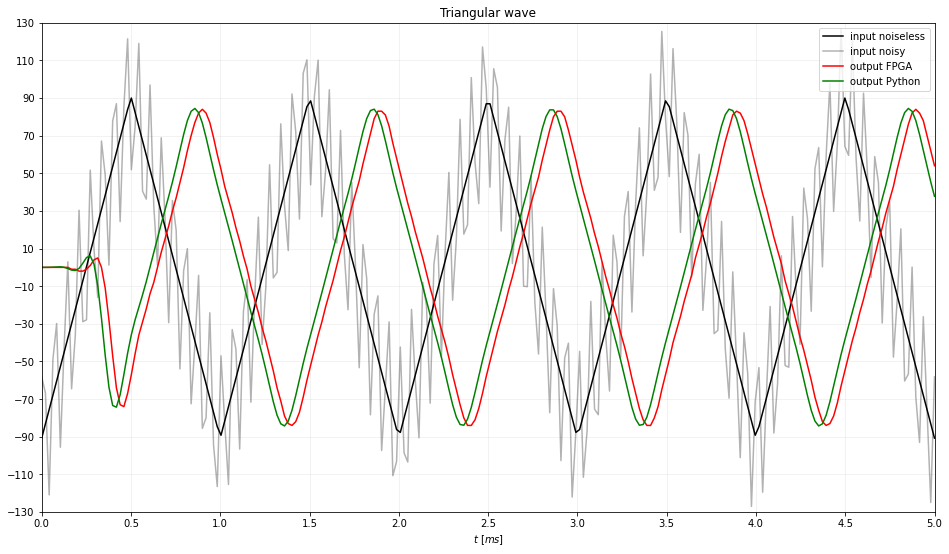

In [11]:
triang = sawtooth(2*np.pi*signal_freq*t, width=0.5)
triang_noisy = add_noise(t, triang, noise_ampl, noise_freq, noise_phase)
process_signal(t, triang, triang_noisy, coeffs, 'Triangular wave')

### **7.4)** *Gaussian pulse*

Filtering the signal through the FPGA...
Done!

Filtering the signal through Python script...
Done!


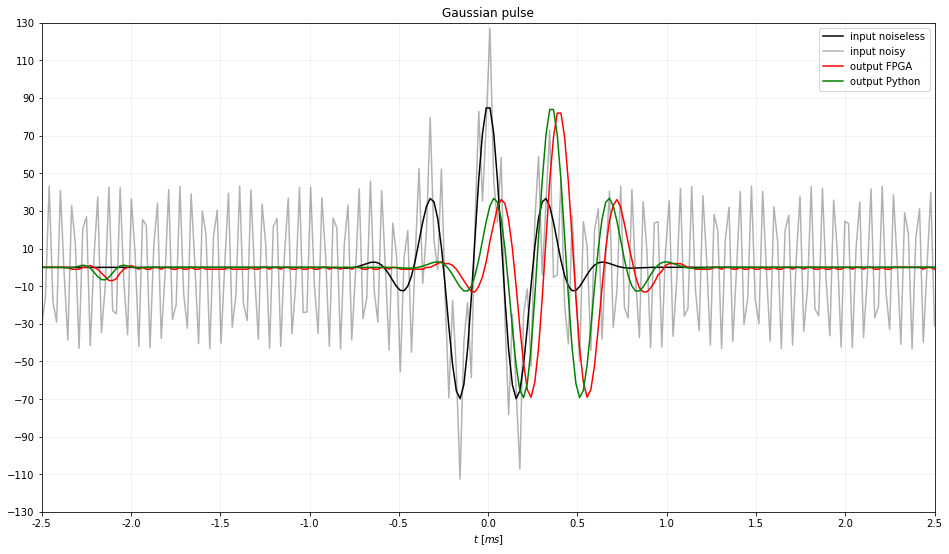

In [12]:
gauss = gausspulse(t-(t[-1]/2), fc=cutoff_freq/2)
gauss_noisy = add_noise(t-(t[-1]/2), gauss, noise_ampl, noise_freq, noise_phase)
process_signal(t-(t[-1]/2), gauss, gauss_noisy, coeffs, 'Gaussian pulse')

### **7.5)** *Sinusoidal wave with unit impulse*

Filtering the signal through the FPGA...
Done!

Filtering the signal through Python script...
Done!


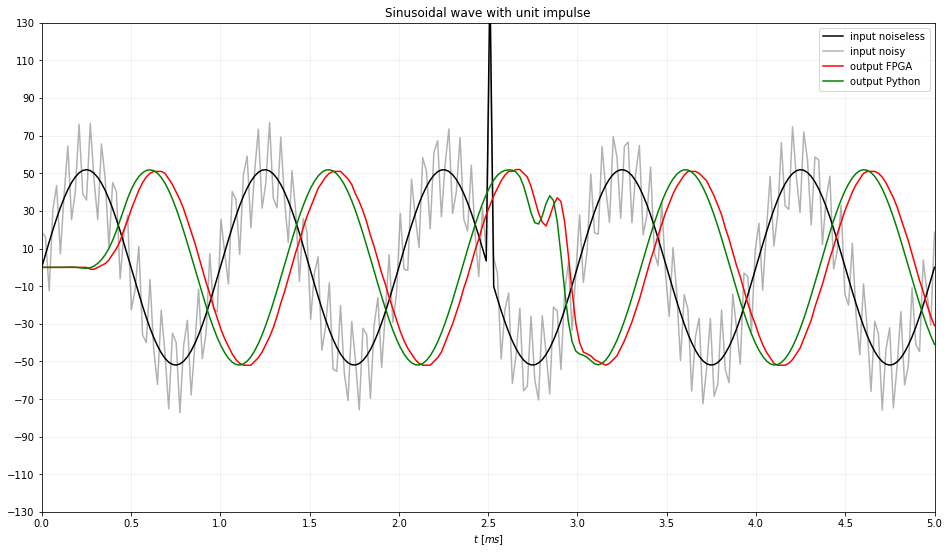

In [13]:
sin_impulse = np.sin(2*np.pi*signal_freq*t) + 3*unit_impulse(len(t), 'mid')
sin_impulse_noisy = add_noise(t, sin_impulse, noise_ampl, noise_freq, noise_phase)
process_signal(t, sin_impulse, sin_impulse_noisy, coeffs, 'Sinusoidal wave with unit impulse')